# Multi label Image Classification using PyTorch

The aim of the project is to predict different genres of a movie simply by its poster. Since a movie can have more than 1 genres, this is a multi label image classification problem.

For this assignment, the dataset we’ll be using contains the poster images of several multi-genre movies.

**Wei-Ta Chu and Hung-Jui Guo, “Movie Genre Classification based on Poster Images with Deep Neural Networks,” Proceedings of International Workshop on Multimodal Understanding of Social, Affective and Subjective Attributes, pp. 39-45, 2017. (in conjunction with ACM Multimedia 2017)**

https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html

The structured and the modified dataset can be downloaded from here

https://drive.google.com/file/d/1iQV5kKF_KGZL9ALx9MMXk_Lg7PklBLCE/view

First, import all the required Python libraries:

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset

from PIL import Image

In [2]:
!pip install jovian --upgrade -q
import jovian

project_name = 'zerotogans-project'

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

**gdown** is a Python library used to download a large file from Google Drive.

In [6]:
!conda install -y gdown

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - rapidsai/linux-64::dask-cudf==0.16.0=py37_g2b8298f566_0
  - conda-forge/noarch::dask==2.30.0=py_0
  - pytorch/linux-64::torchvision==0.8.1=py37_cu102
  - rapidsai/linux-64::cuml==0.16.0=cuda10.2_py37_gbbe737348_0
  - conda-forge/linux-64::gdal==2.4.1=py37h5f563d9_8
  - conda-forge/linux-64::openjpeg==2.3.1=h981e76c_3
  - conda-forge/linux-64::imagemagick==7.0.9_14=pl526h5b29c3e_0
  - conda-forge/linux-64::poppler==0.67.0=h14e79db_8
  - conda-forge/noarch::geopandas==0.6.3=py_0
  - conda-forge/linux-64::libwebp==1.0.2=hf4e8a37_4
  - conda-forge/noarch::pysal==2.1.0=py_0
  - conda-forge/linux-64::gdk-pixbuf==2.38.2=h3f25603_3
  - conda-forge/linux-64::cartopy==0.17.0=py37hd759880_1006
  - conda-forge/linux-64::geotiff==1.4.3=hb6868eb_1001
  - conda-forge/linux-64::libgdal==2.4.1=heae24aa_8
  - conda-forge/linux-64::librsvg==2.50.2=h1f

Download the dataset from the Google Drive link provided above

In [7]:
!gdown --id 1iQV5kKF_KGZL9ALx9MMXk_Lg7PklBLCE

Downloading...
From: https://drive.google.com/uc?id=1iQV5kKF_KGZL9ALx9MMXk_Lg7PklBLCE
To: /kaggle/working/Multi_Label_dataset.zip
259MB [00:06, 39.4MB/s] 


Extract all the files of the .zip file into the working directory

In [8]:
import zipfile
img_zip_path = 'Multi_Label_dataset.zip'
zip_ref = zipfile.ZipFile(img_zip_path, 'r')
zip_ref.extractall()
zip_ref.close()

# Setting up the dataset

Now, let's read the .csv file and look at the first five rows

In [9]:
df = pd.read_csv('Multi_Label_dataset/train.csv')
df.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


The dataset contains 7254 movie posters and 25 columns for all the genres. If a column has 1 in it, that means the genre is present in the movie, or else the genre does not belong to the movie. For example, the first row has 1 for Comedy and Drama column, so its genres are Comedy and Drama.

In [10]:
df.shape

(7254, 27)

We convert the 'Id' column to the Index for this dataset and we remove the 'Genre' column, since we have no use of it.

In [11]:
df['Id'] = df['Id'].apply(lambda x: "{0}.jpg".format(x))
df = df.drop('Genre', axis=1)
df = df.set_index('Id')

The list of genres a movie can have are as follows

In [12]:
genres = df.columns.tolist()
genres

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'N/A',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western']

From the distribution of the genres across all movies, we can see that most movies tend to have comedy, drama, action as its genres. Since it is an unbalanced dataset, there will be a certain bias towards these genres and are more likely to predict such.

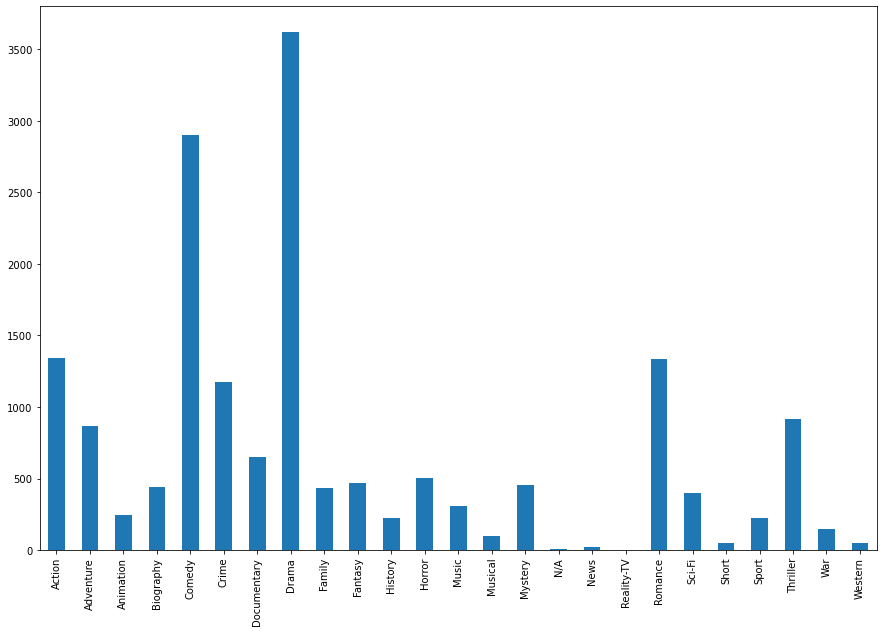

In [13]:
df[genres].sum().plot.bar(figsize=(15,10))

# Loading and preprocessing the dataset

We store all the file names of the images in a variable called *file_names*

In [14]:
file_names = df.index.tolist()

We split the dataset into three parts - Train, Validation and Test. For Train, we use 75% of the dataset, 15% for Validation and 10% for Test. Therefore there are 5440 files for training, 1088 for validation and 725 for testing.

In [15]:
train_size = int(0.75 * len(file_names))
valid_size = int(0.15 * len(file_names))
test_size = int(0.10 * len(file_names))

train_size, valid_size, test_size 

(5440, 1088, 725)

We then shuffle the file order so that all the files are randomly ordered.

In [16]:
shuffle = np.random.permutation(len(file_names))

We create a function called *split_dataset* which will split the shuffled dataset into parts by given indexes and return a Panda Dataframe

In [17]:
def split_dataset(df, file_names, s_index=None, e_index=None):
    d = {}
    for i in tqdm(shuffle[s_index:e_index]):
        file_name = file_names[i]
        labels = [np.array(df[df.index == file_name])]
        d[file_name] = labels
    
    split_df = pd.DataFrame.from_dict(d, orient='index')
    split_df.columns = ['Labels']
    return split_df

In [18]:
train_df = split_dataset(df, file_names, e_index=train_size)
valid_df = split_dataset(df, file_names, s_index=train_size, e_index=train_size+valid_size)
test_df = split_dataset(df, file_names, s_index=train_size+valid_size)

100%|██████████| 726/726 [00:01<00:00, 676.04it/s]


We create a custom dataset by extending the Dataset class from PyTorch. We need to define the __len__ and __getitem__ methods to create a dataset. We'll also provide the option of adding transforms into the constructor.

In [19]:
class MultiLabelImage(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.file_names = dataframe.index
        self.labels = dataframe.Labels.values.tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image = Image.open(os.path.join('Multi_Label_dataset/Images/', self.file_names[index]))
        label = self.labels[index][0]
        sample = {'image': image, 'label': label.astype(float)}
        if self.transform:
            image = self.transform(sample['image'])
            sample = {'image': image, 'label': label.astype(float)}
        return sample

Transforms can be chained using transforms.Compose. For instance, you may add transforms.Resize((256, 256)) before transforms.ToTensor() to resize images to size 256x256 before converting them into tensors.

In [20]:
tfms = transforms.Compose([transforms.Resize((256, 256)),
                           transforms.ToTensor()])

train_dl = MultiLabelImage(train_df, transform = tfms)
valid_dl = MultiLabelImage(valid_df, transform = tfms)
test_dl = MultiLabelImage(test_df, transform = tfms)

Here is a training image from the Train dataset

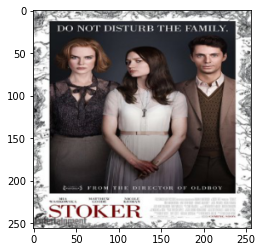

In [21]:
plt.imshow(torchvision.utils.make_grid(train_dl[0]['image']).permute(1, 2, 0))

We can now create data loaders for training and validation, to load the data in batches

In [22]:
batch_size = 64

In [23]:
train_dataloader = torch.utils.data.DataLoader(train_dl, batch_size, shuffle = True, num_workers = 3)
valid_dataloader = torch.utils.data.DataLoader(valid_dl, batch_size, shuffle = True, num_workers = 3)

# Defining the model

Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [24]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch['image'], batch['label']
        out = self(images)                  # Generate predictions
        loss = F.binary_cross_entropy(out, labels.float()) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch['image'], batch['label'] 
        out = self(images)                    # Generate predictions
        loss = F.binary_cross_entropy(out, labels.float())   # Calculate loss
        acc = F_score(out, labels) 
#         acc = accuracy(out, labels) # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [25]:
class MultiClassifier(ImageClassificationBase):
    def __init__(self):
        super(MultiClassifier, self).__init__()

        self.ConvLayer1 = nn.Sequential(
        nn.Conv2d(3, 64, 3), # 3, 256, 256
        nn.MaxPool2d(2,2), # op: 64, 127, 127
        nn.ReLU(), # op: 64, 127, 127
        )
        self.ConvLayer2 = nn.Sequential(
        nn.Conv2d(64, 128, 3), # 64, 127, 127
        nn.MaxPool2d(2,2), #op: 128, 63, 63
        nn.ReLU() # op: 128, 63, 63
        )
        self.ConvLayer3 = nn.Sequential(
        nn.Conv2d(128, 256, 3), # 128, 63, 63
        nn.MaxPool2d(2,2), #op: 256, 30, 30
        nn.ReLU() #op: 256, 30, 30
        )
        self.ConvLayer4 = nn.Sequential(
        nn.Conv2d(256, 512, 3), # 256, 30, 30
        nn.MaxPool2d(2,2), #op: 512, 14, 14
        nn.ReLU(), #op: 512, 14, 14
        nn.Dropout(0.2)
        )
        self.Linear1 = nn.Linear(512 * 14 * 14, 1024)
        self.Linear2 = nn.Linear(1024, 256)
        self.Linear3 = nn.Linear(256, 25)

    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        x = self.Linear3(x)
        return torch.sigmoid(x)

We create a function `F_Score` which calculates the accuracy. If the probablity of a genre is greater than 0.2, the value for that genre is considered to be 1 else it is 0.

In [26]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [56]:
model = MultiClassifier()
model

MultiClassifier(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (Linear1): Linear(in_features=100352, out_features=1024, bias=True)
  (Linear2): Linear(in_features=1024, out_features=256, bias=True)
  (Linear3): Linear(in_features=256, ou

To seamlessly use a GPU, if one is available, we define a couple of helper functions `get_default_device` and `to_device` and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [28]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        return {k:to_device(v, device) for (k, v) in data.items()}
    
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [29]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [57]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
valid_dataloader = DeviceDataLoader(valid_dataloader, device)
to_device(model, device)

MultiClassifier(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (Linear1): Linear(in_features=100352, out_features=1024, bias=True)
  (Linear2): Linear(in_features=1024, out_features=256, bias=True)
  (Linear3): Linear(in_features=256, ou

In [28]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ai/adityapratapsaha/zerotogans-project


<IPython.core.display.Javascript object>

# Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set.

In [31]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we begin training, let's instantiate the model once again and see how it performs on the validation set with the initial set of parameters.

In [58]:
model = to_device(MultiClassifier(), device)

In [51]:
evaluate(model, valid_dataloader)

{'val_loss': 0.6928302049636841, 'val_acc': 0.16789032518863678}

The initial accuracy is around 16%, which is what one might expect from a randomly intialized model.

We'll use the following hyperparmeters (learning rate, no. of epochs, batch_size etc.) to train our model.

In [59]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [60]:
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [61]:
history = fit(num_epochs, lr, model, train_dataloader, valid_dataloader, opt_func)

Epoch [0], train_loss: 0.2743, val_loss: 0.2389, val_acc: 0.4508
Epoch [1], train_loss: 0.2382, val_loss: 0.2337, val_acc: 0.4505
Epoch [2], train_loss: 0.2366, val_loss: 0.2361, val_acc: 0.4487
Epoch [3], train_loss: 0.2362, val_loss: 0.2331, val_acc: 0.4526
Epoch [4], train_loss: 0.2351, val_loss: 0.2364, val_acc: 0.4374
Epoch [5], train_loss: 0.2332, val_loss: 0.2303, val_acc: 0.4554
Epoch [6], train_loss: 0.2307, val_loss: 0.2286, val_acc: 0.4648
Epoch [7], train_loss: 0.2286, val_loss: 0.2300, val_acc: 0.4716
Epoch [8], train_loss: 0.2264, val_loss: 0.2307, val_acc: 0.4519
Epoch [9], train_loss: 0.2235, val_loss: 0.2298, val_acc: 0.4626


Just as we have recorded the hyperparameters, we can also record the final metrics achieved by the model using jovian.log_metrics for reference, analysis and comparison.

In [62]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


We can also plot the validation set accuracies to study how the model improves over time.

In [38]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

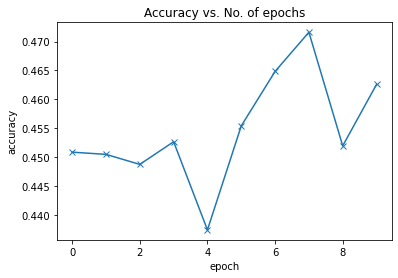

In [63]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [40]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

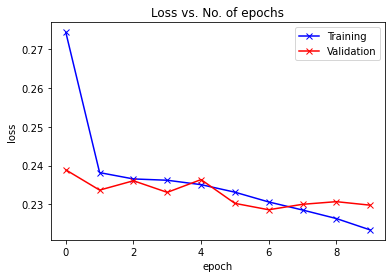

In [64]:
plot_losses(history)

# Predicting Genres

Let's define a helper function `predict_image`, which returns the predicted genres for a single image tensor.

In [42]:
def predict_image(img, model):
    # Convert to a batch of 1
    x = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    y = model(x)
    
    y_b = y > 0.2
    y_i = y_b.float().nonzero(as_tuple=True)[1]
    
    pred_dict = {genres[i]:y[0][i].item() for i in y_i}
    
    preds = sorted(pred_dict.items(), key=lambda x: x[1], reverse=True)
    
    for i in preds:
        print("{0}: {1}".format(i[0], i[1]))

Let's define a helper function `decode_label`, which returns the genres corresponding to its label tensor.

In [43]:
def decode_label(label):
    l = label.nonzero()[0]
    return [genres[i] for i in l]

Let's try predicting the labels for some sample images

Predicted labels

Drama: 0.44443047046661377
Comedy: 0.33790597319602966
Adventure: 0.2045440375804901


Actual labels

['Comedy', 'Drama', 'Family']


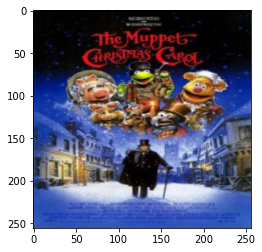

In [65]:
k = 50
plt.imshow(torchvision.utils.make_grid(test_dl[k]['image']).permute(1, 2, 0))

print('Predicted labels\n')
predict_image(test_dl[k]['image'], model)

print('\n')

print('Actual labels\n')
print(decode_label(test_dl[k]['label']))


Predicted labels

Drama: 0.5371711254119873
Action: 0.27699047327041626
Thriller: 0.2207869589328766
Comedy: 0.20663481950759888
Crime: 0.2019886076450348


Actual labels

['Action', 'Adventure', 'Drama']


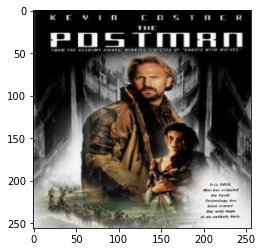

In [66]:
k = 150
plt.imshow(torchvision.utils.make_grid(test_dl[k]['image']).permute(1, 2, 0))

print('Predicted labels\n')
predict_image(test_dl[k]['image'], model)

print('\n')

print('Actual labels\n')
print(decode_label(test_dl[k]['label']))

Predicted labels

Drama: 0.49006950855255127
Action: 0.35896751284599304
Comedy: 0.3062663674354553
Adventure: 0.24200978875160217
Crime: 0.22775281965732574


Actual labels

['Action', 'Crime', 'Thriller']


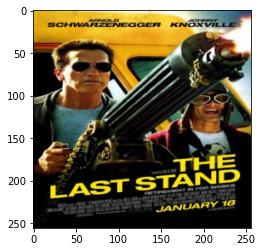

In [67]:
k = 300
plt.imshow(torchvision.utils.make_grid(test_dl[k]['image']).permute(1, 2, 0))

print('Predicted labels\n')
predict_image(test_dl[k]['image'], model)

print('\n')

print('Actual labels\n')
print(decode_label(test_dl[k]['label']))

It would be a good idea to save the weights of the model to disk, so that we can reuse the model later and avoid retraining from scratch by saving the model.

In [68]:
torch.save(model.state_dict(), 'movie_genres.pth')

# Conclusion

Our model returns an accuracy of 46-47%, which leaves a lot of room for improvements. Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters, implementing normalization, regularization.

Since the dataset contains more examples for certain genres than other genres, it becomes hard to predict minority genres such as Animation, War, Musical etc. For this reason, we need to create the dataset in such a way that all the genre categories will have comparatively equal distribution.

# References

* https://www.analyticsvidhya.com/blog/2019/04/build-first-multi-label-image-classification-model-python/
* https://medium.com/@thevatsalsaglani/training-and-deploying-a-multi-label-image-classifier-using-pytorch-flask-reactjs-and-firebase-c39c96f9c427
* https://jovian.ai/aakashns/simple-cnn-starter
* https://jovian.ai/aakashns/05-cifar10-cnn
* https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

In [69]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/adityapratapsaha/zerotogans-project


<IPython.core.display.Javascript object>